### Dataset, Dataloader

In [21]:
#config.py
path_ = '/content/drive/MyDrive/CFT/HW2_torch'
path_data = '/content/cifar10/cifar10'
batch_size=16
seed = 12345
save_path_ = path_ + '/checkpoint/'
learning_rate = 1e-4
epochs = 30

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!unzip -qq /content/drive/MyDrive/CFT/HW2_torch/data/archive.zip

replace cifar10/cifar10/test/airplane/0001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Create DF

In [24]:
import glob
import pandas as pd
from sklearn import preprocessing
from pathlib import Path

def pivot_df_data(
    train_path: str
) -> pd.DataFrame:
    '''
    Create data frame train and test data
    path|str(label)|train or test|int(label)
    '''
    
    p = Path(train_path.replace('\\','\/'))

    labels = [x.name for x in p.iterdir()]
    le = preprocessing.LabelEncoder()
    targets = le.fit_transform(labels)

    # Датафрейм для работы с данными
    df = pd.DataFrame({'image': glob.glob(train_path + '/*/*/*.png')})
    df['label'] = df['image'].apply(lambda p: p.split('/')[-2])
    df['split'] = df['image'].apply(lambda p: p.split('/')[-3])
    df['int_label'] = le.fit_transform(df['label'])

    return df

### CifarDataset

In [25]:
from torch.utils.data import Dataset
from PIL import Image
from typing import Tuple
from torchvision.transforms import transforms
import torch

class CifarDataset(Dataset):
    
    def __init__(self, df: pd.DataFrame, mode: str, transforms: transforms):
        self.df = df[df.split == mode]
        self.transforms = transforms
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        row = self.df.iloc[index, :]
        image = Image.open(row['image'])
        label = row['int_label']

        if self.transforms:
            # Аугментация
            image = self.transforms(image)

        return image, label
    
    def __len__(self):
        return len(self.df)

Model

### SimpleCNN

In [26]:
# model

import torch.nn.functional as F
import torch.nn as nn


class SimpleCNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
        self.pool = nn.MaxPool2d(3, 2)
        self.dropout = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(in_features=128, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc2(x)
        return out

### CifarDataLoader

In [27]:
from torchvision.transforms import transforms
import torch
#from CifarDataset import CifarDataset


def CifarDataLoader(
    df: pd.DataFrame
  ) -> Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:

    transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                     (0.2023, 0.1994, 0.2010)),
            ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), 
                             (0.2023, 0.1994, 0.2010)),
    ])

    train_dataset = CifarDataset(
        df, 
        mode='train',
        transforms=transform_train
    )

    test_dataset = CifarDataset(
        df, 
        mode='test', 
        transforms=transform_test
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=2,
        pin_memory=True,
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset, 
        batch_size=1,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )
    return train_loader, test_loader

### Train_one_epoch

In [28]:
from tqdm import tqdm
import torch
from typing import Callable
from torch.optim import Optimizer


def train_one_epoch(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: Callable,
) -> Tuple[float, float]:

    model.train() 

    train_running_loss = 0.0
    train_running_correct = 0
    total_epoch_steps = int(len(dataloader.dataset)/dataloader.batch_size)

    for _, batch in tqdm(enumerate(dataloader), total=total_epoch_steps):
        images, target = batch
        images, target = images.to(device), target.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, target)
        train_running_loss += loss.item()

        _, preds = torch.max(outputs.data, 1) # можем не использовать softmax, а просто взять .max
        train_running_correct += (preds == target).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(dataloader.dataset)    
    return train_loss, train_accuracy

### Validate

In [29]:
from tqdm import tqdm
import torch
from typing import Callable

def validate(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    criterion: Callable
) -> Tuple[float, float]:

    model.eval()

    val_running_loss = 0.0
    val_running_correct = 0

    with torch.no_grad():
        inference_steps = int(len(dataloader.dataset)/dataloader.batch_size)

        for _, batch in tqdm(enumerate(dataloader), total=inference_steps):
            
            images, target = batch
            images = images.to(device)
            target = target.to(device)

            outputs = model(images)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss/len(dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(dataloader.dataset)        
        return val_loss, val_accuracy

### Fix_seed

In [30]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = True

### Resume_training

In [31]:
from os import path
def save_training(
    current_epoch: int, 
    model: nn.Module, 
    optimizer: torch.optim.Optimizer,
    name_model: str
  ):
  '''
  сохраняем текущее состояние модели
  '''
  import torch

  save_path = save_path_ + f'{name_model}.ckpt'

  torch.save({
      'epoch': current_epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
  }, save_path)

In [32]:
from typing import Tuple
import torch
def resume_training(
    save_path: str
  ):
  
  checkpoint = torch.load(save_path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']

  return model, optimizer, epoch

In [33]:
import matplotlib.pyplot as plt
#from CifarDataLoader import CifarDataLoader
#from train_one_epoch import train_one_epoch
#from validate import validate
#from save_training import save_training

def train_model(
    model: nn.Module, 
    learning_rate: float, 
    optimizer: torch.optim.Optimizer, 
    criterion: Callable, 
    epochs: int, 
    df: pd.DataFrame, 
    current_epoch: int = 0):

    train_loader, test_loader = CifarDataLoader(df)

    train_loss , train_accuracy = [], []

    for epoch in range(current_epoch, epochs):

        print(f"Epoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_accuracy = train_one_epoch(
                                                          model,
                                                          train_loader, 
                                                          optimizer, 
                                                          criterion
                                                        )

        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)

        print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")

        val_loss, val_accuracy = validate(model, test_loader, criterion)
        print(f"Test Loss: {val_loss:.4f}, Test Acc: {val_accuracy:.2f}")

        if epoch == 15:
          save_training(
                    epoch, 
                    model, 
                    optimizer,
                    name_model=f'model_{epoch}_epochs'
          )

    plt.figure(figsize=(10, 7))
    plt.plot(train_accuracy, color='green', label='train accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(path_ + '/Reports/train_acc_epoch.png')
    
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(path_ + '/Reports/train_loss_epoch.png')

    save_training(
                    epoch, 
                    model, 
                    optimizer,
                    name_model=f'final_model'
          )

Epoch 1 of 30


  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 3125/3125 [01:00<00:00, 51.75it/s]

Train Loss: 0.1146, Train Acc: 32.69



100%|██████████| 10000/10000 [00:39<00:00, 254.82it/s]

Test Loss: 1.4687, Test Acc: 47.00
Epoch 2 of 30



100%|██████████| 3125/3125 [00:59<00:00, 52.84it/s]

Train Loss: 0.0945, Train Acc: 45.46



100%|██████████| 10000/10000 [00:38<00:00, 258.65it/s]

Test Loss: 1.2538, Test Acc: 56.12
Epoch 3 of 30



100%|██████████| 3125/3125 [00:59<00:00, 52.70it/s]

Train Loss: 0.0853, Train Acc: 51.24



100%|██████████| 10000/10000 [00:38<00:00, 257.06it/s]

Test Loss: 1.1828, Test Acc: 58.10
Epoch 4 of 30



100%|██████████| 3125/3125 [00:58<00:00, 53.49it/s]

Train Loss: 0.0793, Train Acc: 55.30



100%|██████████| 10000/10000 [00:38<00:00, 259.33it/s]

Test Loss: 1.0958, Test Acc: 62.52
Epoch 5 of 30



100%|██████████| 3125/3125 [00:58<00:00, 53.34it/s]

Train Loss: 0.0749, Train Acc: 57.89



100%|██████████| 10000/10000 [00:38<00:00, 259.54it/s]

Test Loss: 1.0048, Test Acc: 65.66
Epoch 6 of 30



100%|██████████| 3125/3125 [00:58<00:00, 53.73it/s]

Train Loss: 0.0713, Train Acc: 60.24



100%|██████████| 10000/10000 [00:38<00:00, 262.79it/s]

Test Loss: 0.9741, Test Acc: 66.45
Epoch 7 of 30



100%|██████████| 3125/3125 [00:58<00:00, 53.35it/s]

Train Loss: 0.0678, Train Acc: 62.30



100%|██████████| 10000/10000 [00:37<00:00, 264.59it/s]

Test Loss: 0.9019, Test Acc: 69.03
Epoch 8 of 30



100%|██████████| 3125/3125 [01:00<00:00, 51.79it/s]

Train Loss: 0.0655, Train Acc: 63.61



100%|██████████| 10000/10000 [00:37<00:00, 263.67it/s]

Test Loss: 0.8824, Test Acc: 70.58
Epoch 9 of 30



100%|██████████| 3125/3125 [00:59<00:00, 52.35it/s]

Train Loss: 0.0631, Train Acc: 65.03



100%|██████████| 10000/10000 [00:38<00:00, 261.85it/s]

Test Loss: 0.8683, Test Acc: 70.51
Epoch 10 of 30



100%|██████████| 3125/3125 [01:01<00:00, 50.90it/s]

Train Loss: 0.0613, Train Acc: 66.09



100%|██████████| 10000/10000 [00:38<00:00, 257.76it/s]

Test Loss: 0.8129, Test Acc: 72.22
Epoch 11 of 30



100%|██████████| 3125/3125 [01:01<00:00, 51.03it/s]

Train Loss: 0.0592, Train Acc: 67.36



100%|██████████| 10000/10000 [00:38<00:00, 258.83it/s]

Test Loss: 0.8026, Test Acc: 72.81
Epoch 12 of 30



100%|██████████| 3125/3125 [00:58<00:00, 53.20it/s]

Train Loss: 0.0578, Train Acc: 68.05



100%|██████████| 10000/10000 [00:38<00:00, 261.67it/s]

Test Loss: 0.7707, Test Acc: 73.94
Epoch 13 of 30



100%|██████████| 3125/3125 [00:57<00:00, 54.37it/s]

Train Loss: 0.0564, Train Acc: 68.69



100%|██████████| 10000/10000 [00:38<00:00, 260.61it/s]

Test Loss: 0.7569, Test Acc: 73.89
Epoch 14 of 30



100%|██████████| 3125/3125 [00:57<00:00, 54.22it/s]

Train Loss: 0.0550, Train Acc: 69.41



100%|██████████| 10000/10000 [00:37<00:00, 263.22it/s]

Test Loss: 0.7443, Test Acc: 74.66
Epoch 15 of 30



100%|██████████| 3125/3125 [00:57<00:00, 54.21it/s]

Train Loss: 0.0541, Train Acc: 70.12



100%|██████████| 10000/10000 [00:38<00:00, 261.03it/s]

Test Loss: 0.7266, Test Acc: 74.77
Epoch 16 of 30



100%|██████████| 3125/3125 [00:58<00:00, 53.34it/s]

Train Loss: 0.0531, Train Acc: 70.80



100%|██████████| 10000/10000 [00:37<00:00, 265.59it/s]


Test Loss: 0.7132, Test Acc: 75.61
Epoch 17 of 30


100%|██████████| 3125/3125 [00:58<00:00, 53.78it/s]

Train Loss: 0.0521, Train Acc: 71.13



100%|██████████| 10000/10000 [00:38<00:00, 262.15it/s]

Test Loss: 0.7001, Test Acc: 76.17
Epoch 18 of 30



100%|██████████| 3125/3125 [00:57<00:00, 54.45it/s]

Train Loss: 0.0513, Train Acc: 71.74



100%|██████████| 10000/10000 [00:38<00:00, 262.66it/s]

Test Loss: 0.7199, Test Acc: 75.38
Epoch 19 of 30



100%|██████████| 3125/3125 [00:57<00:00, 54.61it/s]

Train Loss: 0.0505, Train Acc: 72.07



100%|██████████| 10000/10000 [00:38<00:00, 263.06it/s]

Test Loss: 0.6930, Test Acc: 76.19
Epoch 20 of 30



100%|██████████| 3125/3125 [00:57<00:00, 54.39it/s]

Train Loss: 0.0499, Train Acc: 72.44



100%|██████████| 10000/10000 [00:37<00:00, 263.53it/s]

Test Loss: 0.6774, Test Acc: 76.69
Epoch 21 of 30



100%|██████████| 3125/3125 [00:56<00:00, 55.13it/s]

Train Loss: 0.0490, Train Acc: 72.97



100%|██████████| 10000/10000 [00:37<00:00, 263.91it/s]

Test Loss: 0.6701, Test Acc: 77.19
Epoch 22 of 30



100%|██████████| 3125/3125 [00:57<00:00, 54.64it/s]

Train Loss: 0.0483, Train Acc: 73.51



100%|██████████| 10000/10000 [00:38<00:00, 262.89it/s]

Test Loss: 0.6639, Test Acc: 77.50
Epoch 23 of 30



100%|██████████| 3125/3125 [00:57<00:00, 53.90it/s]

Train Loss: 0.0480, Train Acc: 73.59



100%|██████████| 10000/10000 [00:37<00:00, 267.01it/s]

Test Loss: 0.6825, Test Acc: 76.36
Epoch 24 of 30



100%|██████████| 3125/3125 [00:58<00:00, 53.18it/s]


Train Loss: 0.0470, Train Acc: 73.92


100%|██████████| 10000/10000 [00:38<00:00, 259.42it/s]

Test Loss: 0.6430, Test Acc: 78.02
Epoch 25 of 30



100%|██████████| 3125/3125 [00:56<00:00, 55.06it/s]

Train Loss: 0.0469, Train Acc: 74.15



100%|██████████| 10000/10000 [00:38<00:00, 261.84it/s]

Test Loss: 0.6411, Test Acc: 78.08
Epoch 26 of 30



100%|██████████| 3125/3125 [00:57<00:00, 54.42it/s]

Train Loss: 0.0458, Train Acc: 74.84



100%|██████████| 10000/10000 [00:38<00:00, 261.71it/s]

Test Loss: 0.6492, Test Acc: 77.74
Epoch 27 of 30



100%|██████████| 3125/3125 [00:57<00:00, 54.30it/s]

Train Loss: 0.0453, Train Acc: 74.97



100%|██████████| 10000/10000 [00:38<00:00, 262.91it/s]

Test Loss: 0.6387, Test Acc: 78.23
Epoch 28 of 30



100%|██████████| 3125/3125 [00:57<00:00, 54.13it/s]

Train Loss: 0.0457, Train Acc: 74.63



100%|██████████| 10000/10000 [00:38<00:00, 262.30it/s]

Test Loss: 0.6291, Test Acc: 78.39
Epoch 29 of 30



100%|██████████| 3125/3125 [00:56<00:00, 55.09it/s]

Train Loss: 0.0447, Train Acc: 75.35



100%|██████████| 10000/10000 [00:38<00:00, 262.08it/s]

Test Loss: 0.6232, Test Acc: 78.74
Epoch 30 of 30



100%|██████████| 3125/3125 [00:57<00:00, 54.11it/s]

Train Loss: 0.0443, Train Acc: 75.42



100%|██████████| 10000/10000 [00:38<00:00, 261.74it/s]


Test Loss: 0.6221, Test Acc: 78.57


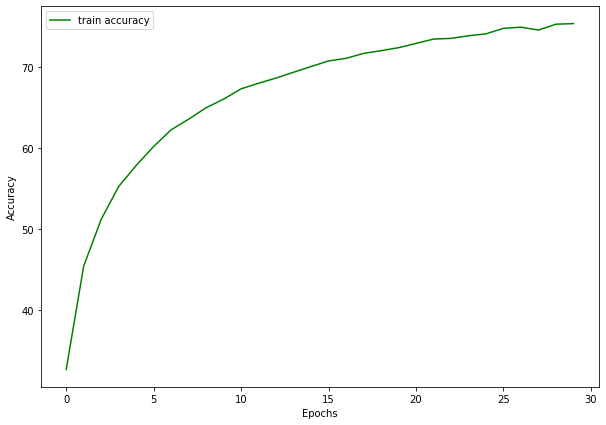

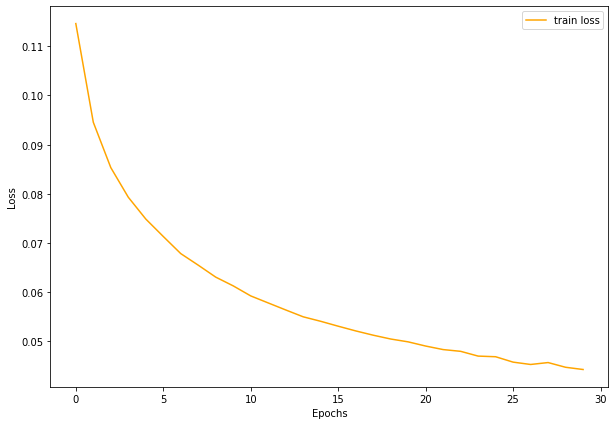

In [34]:
#from fix_seed import seed_everything
#from create_df import pivot_df_data
#from model_SNN import SimpleCNN
import torch
import torch.nn as nn

seed_everything(seed)
df = pivot_df_data(path_data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_model(
    model, 
    learning_rate, 
    optimizer, 
    criterion, 
    epochs=epochs, 
    df = df
  )

### HW_resume training

In [35]:
model_final = resume_training('/content/drive/MyDrive/CFT/HW2_torch/checkpoint/final_model.ckpt')[0]

In [36]:
model_resume, optimizer, epoch  = resume_training('/content/drive/MyDrive/CFT/HW2_torch/checkpoint/model_15_epochs.ckpt')

Epoch 16 of 30


100%|██████████| 3125/3125 [01:10<00:00, 44.35it/s]

Train Loss: 0.0519, Train Acc: 71.27



100%|██████████| 10000/10000 [00:38<00:00, 257.31it/s]

Test Loss: 0.7258, Test Acc: 75.09
Epoch 17 of 30



100%|██████████| 3125/3125 [00:57<00:00, 54.21it/s]

Train Loss: 0.0514, Train Acc: 71.66



100%|██████████| 10000/10000 [00:38<00:00, 261.32it/s]

Test Loss: 0.7061, Test Acc: 75.68
Epoch 18 of 30



100%|██████████| 3125/3125 [00:57<00:00, 54.23it/s]

Train Loss: 0.0504, Train Acc: 72.11



100%|██████████| 10000/10000 [00:38<00:00, 261.25it/s]

Test Loss: 0.6827, Test Acc: 76.83
Epoch 19 of 30



100%|██████████| 3125/3125 [00:57<00:00, 54.33it/s]

Train Loss: 0.0496, Train Acc: 72.43



100%|██████████| 10000/10000 [00:38<00:00, 261.82it/s]

Test Loss: 0.6975, Test Acc: 76.42
Epoch 20 of 30



100%|██████████| 3125/3125 [00:58<00:00, 53.54it/s]

Train Loss: 0.0486, Train Acc: 73.24



100%|██████████| 10000/10000 [00:37<00:00, 264.14it/s]

Test Loss: 0.6743, Test Acc: 77.14
Epoch 21 of 30



100%|██████████| 3125/3125 [00:58<00:00, 53.27it/s]

Train Loss: 0.0484, Train Acc: 73.23



100%|██████████| 10000/10000 [00:38<00:00, 258.15it/s]

Test Loss: 0.6633, Test Acc: 77.35
Epoch 22 of 30



100%|██████████| 3125/3125 [00:58<00:00, 53.40it/s]


Train Loss: 0.0479, Train Acc: 73.53


100%|██████████| 10000/10000 [00:38<00:00, 260.87it/s]

Test Loss: 0.6616, Test Acc: 77.57
Epoch 23 of 30



100%|██████████| 3125/3125 [00:57<00:00, 53.92it/s]

Train Loss: 0.0468, Train Acc: 74.17



100%|██████████| 10000/10000 [00:38<00:00, 262.68it/s]

Test Loss: 0.6540, Test Acc: 77.88
Epoch 24 of 30



100%|██████████| 3125/3125 [00:58<00:00, 53.17it/s]

Train Loss: 0.0464, Train Acc: 74.50



100%|██████████| 10000/10000 [00:38<00:00, 260.36it/s]

Test Loss: 0.6538, Test Acc: 77.77
Epoch 25 of 30



100%|██████████| 3125/3125 [00:59<00:00, 52.65it/s]

Train Loss: 0.0460, Train Acc: 74.73



100%|██████████| 10000/10000 [00:38<00:00, 262.14it/s]

Test Loss: 0.6486, Test Acc: 77.79
Epoch 26 of 30



100%|██████████| 3125/3125 [00:57<00:00, 54.44it/s]


Train Loss: 0.0455, Train Acc: 74.82


100%|██████████| 10000/10000 [00:38<00:00, 260.13it/s]

Test Loss: 0.6396, Test Acc: 77.74
Epoch 27 of 30



100%|██████████| 3125/3125 [00:58<00:00, 53.43it/s]

Train Loss: 0.0449, Train Acc: 75.32



100%|██████████| 10000/10000 [00:38<00:00, 257.98it/s]

Test Loss: 0.6343, Test Acc: 78.18
Epoch 28 of 30



100%|██████████| 3125/3125 [01:00<00:00, 51.90it/s]

Train Loss: 0.0446, Train Acc: 75.32



100%|██████████| 10000/10000 [00:38<00:00, 261.35it/s]

Test Loss: 0.6226, Test Acc: 78.96
Epoch 29 of 30



100%|██████████| 3125/3125 [00:59<00:00, 52.61it/s]

Train Loss: 0.0439, Train Acc: 75.68



100%|██████████| 10000/10000 [00:39<00:00, 254.33it/s]

Test Loss: 0.6290, Test Acc: 78.82
Epoch 30 of 30



100%|██████████| 3125/3125 [00:57<00:00, 54.03it/s]

Train Loss: 0.0442, Train Acc: 75.65



100%|██████████| 10000/10000 [00:38<00:00, 262.79it/s]


Test Loss: 0.6201, Test Acc: 78.99


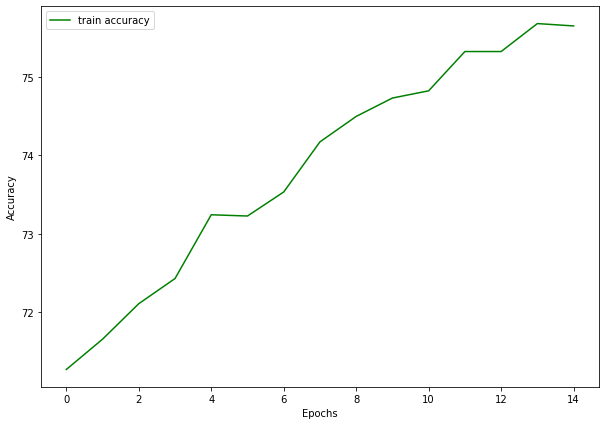

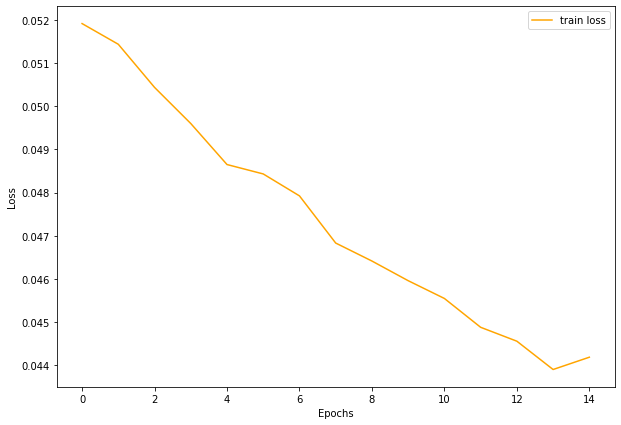

In [37]:
train_model(
    model_resume, 
    learning_rate, 
    optimizer, 
    criterion, 
    epochs=30, 
    df = df,
    current_epoch=epoch
  )

In [38]:
model_final == model_resume

True